In [1]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

import matplotlib.pyplot as plt

from saved_class_Animator import Animator
from saved_class_Timer import Timer
from saved_class_Accumulator import Accumulator

from saved_func_update_D import update_D
from saved_func_update_G import update_G

Tensorflow version:  2.4.1


In [2]:
import os
import zipfile
import hashlib
import requests

## 17.2.1. The Pokemon Dataset

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [5]:
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB = dict()

DATA_HUB['pokemon'] = (DATA_URL + 'pokemon.zip', 'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = download_extract('pokemon')

In [6]:
batch_size = 256
pokemon = tf.keras.preprocessing.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = (64, 64))

Found 40597 files belonging to 721 classes.


In [7]:
transformer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.Normalization(mean = 0.5, variance = 0.25)
])
data_iter = pokemon.map(lambda x, y: (transformer(x), y), num_parallel_calls= tf.data.AUTOTUNE)
data_iter = data_iter.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [8]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

<Figure size 288x288 with 0 Axes>

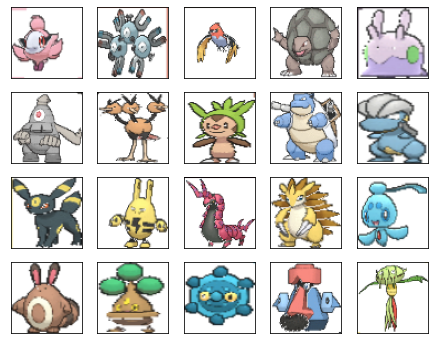

In [9]:
plt.figure(figsize = (4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    show_images(imgs, num_rows = 4, num_cols = 5)

## The Generator

In [10]:
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size = 4, strides = 2, padding = "same", **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(out_channels, kernel_size, strides, padding, use_bias = False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()
        
    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [11]:
x = tf.zeros((2, 16, 16, 3))   # Channel last convention
g_blk = G_block(20)
g_blk(x).shape

TensorShape([2, 32, 32, 20])

In [12]:
x = tf.zeros((2, 1, 1, 3))
g_blk = G_block(20, strides = 1, padding= "valid") # `padding = "valid"` corresponds to no padding
g_blk(x).shape

TensorShape([2, 4, 4, 20])

In [13]:
n_G = 64
net_G = tf.keras.Sequential([
    G_block(out_channels = n_G * 8, strides = 1, padding = "valid"),  # Output: (4, 4, 64 * 8)
    G_block(out_channels = n_G * 4), # Output: (8, 8, 64 * 4)
    G_block(out_channels = n_G * 2), # Output: (16, 16, 64 * 2)
    G_block(out_channels = n_G), # Output: (32, 32, 64)
    tf.keras.layers.Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = "same", use_bias = False, activation = "tanh") # Output: (64, 64, 3)
])

In [14]:
x = tf.zeros((1, 1, 1, 100))  # 1 batch, image width = 1, image height = 1, image depth (channels) = 100
net_G(x).shape

TensorShape([1, 64, 64, 3])

## 17.2.3. Discriminator

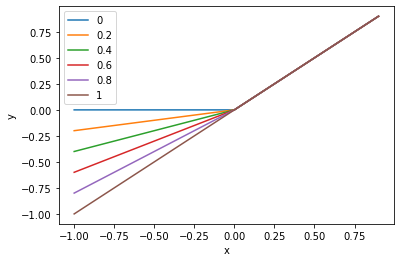

In [15]:
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
x = tf.range(start = -1, limit = 1, delta = 0.1)
Y = tf.constant([tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas])
plt.plot(x, tf.transpose(Y))
plt.xlabel("x")
plt.ylabel("y")
plt.legend(alphas)
plt.show()

In [16]:
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size = 4, strides = 2, padding = "same", alpha = 0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size, strides, padding, use_bias = False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)
        
    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [17]:
x = tf.zeros((2, 16, 16, 3))
d_blk = D_block(20)
d_blk(x).shape

TensorShape([2, 8, 8, 20])

In [18]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels = n_D * 2), # Output: (16, 16, 64 * 2)
    D_block(out_channels = n_D * 4), # Output: (8, 8, 64 * 4)
    D_block(out_channels = n_D * 8), # Outupt: (4, 4, 64 * 64)
    tf.keras.layers.Conv2D(1, kernel_size = 4, use_bias = False) # Output: (1, 1, 1)
])

In [19]:
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## 17.2.4. Training

In [20]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return f'/GPU:{i}'
    return f'/CPU:0'

In [21]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device = try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.SUM)
    
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean = 0, stddev = 0.02, shape = w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean = 0, stddev = 0.02, shape = w.shape))
    
    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)
    
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], nrows=2,
                        figsize=(5, 5), legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace = 0.3)
    
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = Timer()
        metric = Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean = 0, stddev = 1, shape = (batch_size, 1, 1, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)
            
        # Show generated examples
        Z = tf.random.normal(mean = 0, stddev = 1, shape = (21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)], axis = 1) 
                          for i in range(len(fake_x) // 7)], axis = 0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.210, loss_G 3.733, 1480.4 examples/sec on /GPU:0


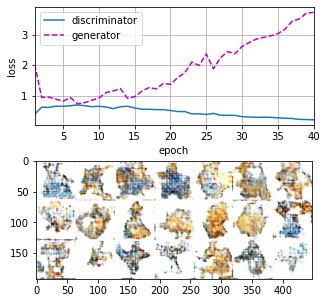

In [22]:
latent_dim, lr, num_epochs = 100, 0.0005, 40  # We have changed the learning rate and number of epochs 
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)